In [1]:

# Load pickled data
import pickle
import matplotlib.pyplot as plt
from IPython.display import Image
import pandas as pd
from matplotlib import gridspec

%matplotlib inline

# TODO: Fill this in based on where you saved the training and testing data

training_file = './imgs/train.p'
testing_file = './imgs/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### Replace each question mark with the appropriate value.
import numpy as np

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (34799, 32, 32, 3)
Number of classes = 43


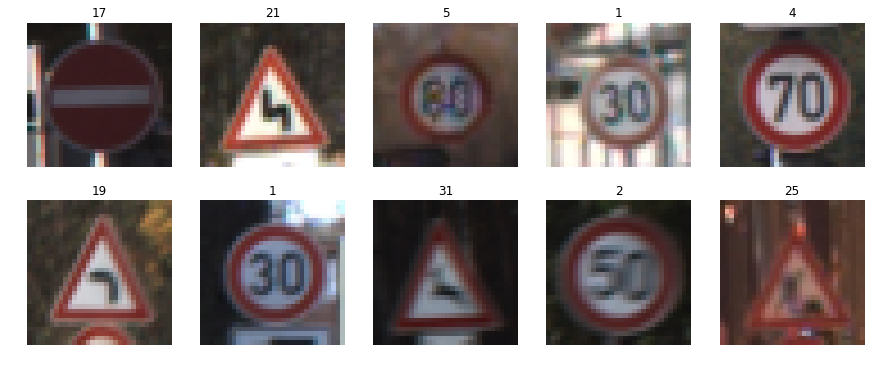

In [6]:

### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
# Visualizations will be shown in the notebook.
%matplotlib inline

# show image of 10 random data points
fig, axs = plt.subplots(2,5, figsize=(15, 6))
#fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i].imshow(image)
    axs[i].axis('off')
    axs[i].set_title(y_train[index])



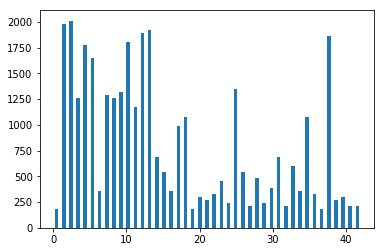

In [7]:

# histogram of label frequency
hist, bins = np.histogram(y_train, bins=n_classes)
width = 0.5 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

## Model architecure

In [8]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

# Convert to grayscale
X_train_rgb = X_train
X_train_gry = np.sum(X_train/3, axis=3, keepdims=True)

X_test_rgb = X_test
X_test_gry = np.sum(X_test/3, axis=3, keepdims=True)

print('RGB shape:', X_train_rgb.shape)
print('Grayscale shape:', X_train_gry.shape)

RGB shape: (34799, 32, 32, 3)
Grayscale shape: (34799, 32, 32, 1)


In [9]:
X_train = X_train_gry
X_test = X_test_gry

In [10]:
X_train_normalized = (X_train - 128)/128 
X_test_normalized = (X_test - 128)/128

shape in/out: (32, 32, 1) (32, 32, 1)


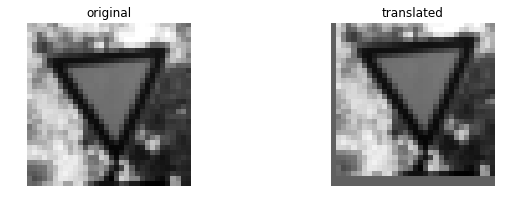

In [12]:
import cv2
def random_translate(img):
    rows,cols,_ = img.shape
    
    # allow translation up to px pixels in x and y directions
    px = 2
    dx,dy = np.random.randint(-px,px,2)

    M = np.float32([[1,0,dx],[0,1,dy]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

test_img = X_train_normalized[22222]

test_dst = random_translate(test_img)

fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(test_img.squeeze(), cmap='gray')
axs[0].set_title('original')

axs[1].axis('off')
axs[1].imshow(test_dst.squeeze(), cmap='gray')
axs[1].set_title('translated')

print('shape in/out:', test_img.shape, test_dst.shape)

shape in/out: (32, 32, 1) (32, 32, 1)


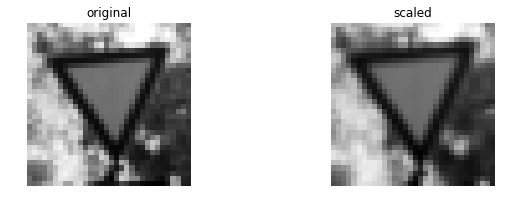

In [13]:
def random_scaling(img):   
    rows,cols,_ = img.shape

    # transform limits
    px = np.random.randint(-2,2)

    # ending locations
    pts1 = np.float32([[px,px],[rows-px,px],[px,cols-px],[rows-px,cols-px]])

    # starting locations (4 corners)
    pts2 = np.float32([[0,0],[rows,0],[0,cols],[rows,cols]])

    M = cv2.getPerspectiveTransform(pts1,pts2)

    dst = cv2.warpPerspective(img,M,(rows,cols))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

test_dst = random_scaling(test_img)
    
fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(test_img.squeeze(), cmap='gray')
axs[0].set_title('original')

axs[1].axis('off')
axs[1].imshow(test_dst.squeeze(), cmap='gray')
axs[1].set_title('scaled')

print('shape in/out:', test_img.shape, test_dst.shape)

shape in/out: (32, 32, 1) (32, 32, 1)


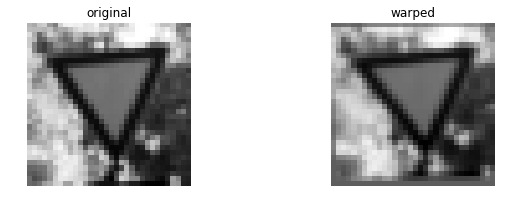

In [14]:
def random_warp(img):
    
    rows,cols,_ = img.shape

    # random scaling coefficients
    rndx = np.random.rand(3) - 0.5
    rndx *= cols * 0.06   # this coefficient determines the degree of warping
    rndy = np.random.rand(3) - 0.5
    rndy *= rows * 0.06

    # 3 starting points for transform, 1/4 way from edges
    x1 = cols/4
    x2 = 3*cols/4
    y1 = rows/4
    y2 = 3*rows/4

    pts1 = np.float32([[y1,x1],
                       [y2,x1],
                       [y1,x2]])
    pts2 = np.float32([[y1+rndy[0],x1+rndx[0]],
                       [y2+rndy[1],x1+rndx[1]],
                       [y1+rndy[2],x2+rndx[2]]])

    M = cv2.getAffineTransform(pts1,pts2)

    dst = cv2.warpAffine(img,M,(cols,rows))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

test_dst = random_warp(test_img)

fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(test_img.squeeze(), cmap='gray')
axs[0].set_title('original')

axs[1].axis('off')
axs[1].imshow(test_dst.squeeze(), cmap='gray')
axs[1].set_title('warped')

print('shape in/out:', test_img.shape, test_dst.shape)

shape in/out: (32, 32, 1) (32, 32, 1)


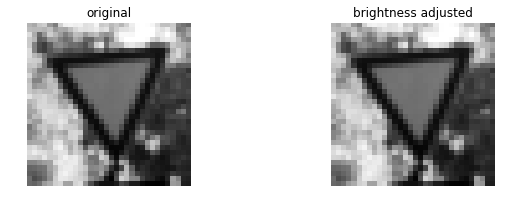

In [15]:
def random_brightness(img):
    shifted = img + 1.0   # shift to (0,2) range
    img_max_value = max(shifted.flatten())
    max_coef = 2.0/img_max_value
    min_coef = max_coef - 0.1
    coef = np.random.uniform(min_coef, max_coef)
    dst = shifted * coef - 1.0
    return dst

test_dst = random_brightness(test_img)

fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(test_img.squeeze(), cmap='gray')
axs[0].set_title('original')

axs[1].axis('off')
axs[1].imshow(test_dst.squeeze(), cmap='gray')
axs[1].set_title('brightness adjusted')

print('shape in/out:', test_img.shape, test_dst.shape)

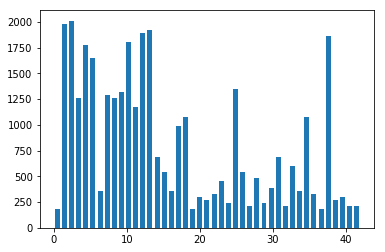

In [16]:
# histogram of label frequency (once again, before data augmentation)
hist, bins = np.histogram(y_train, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

In [17]:
input_indices = []
output_indices = []

for class_n in range(n_classes):
    print(class_n, ': ', end='')
    class_indices = np.where(y_train == class_n)
    n_samples = len(class_indices[0])
    if n_samples < 800:
        for i in range(800 - n_samples):
            input_indices.append(class_indices[0][i%n_samples])
            output_indices.append(X_train_normalized.shape[0])
            new_img = X_train_normalized[class_indices[0][i % n_samples]]
            new_img = random_translate(random_scaling(random_warp(random_brightness(new_img))))
            X_train_normalized = np.concatenate((X_train_normalized, [new_img]), axis=0)
            y_train = np.concatenate((y_train, [class_n]), axis=0)
            if i % 50 == 0:
                print('|', end='')
            elif i % 10 == 0:
                print('-',end='')
    print('')
            
print('X, y shapes:', X_train_normalized.shape, y_train.shape)

0 : |----|----|----|----|----|----|----|----|----|----|----|----|-
1 : 
2 : 
3 : 
4 : 
5 : 
6 : |----|----|----|----|----|----|----|----|---
7 : 
8 : 
9 : 
10 : 
11 : 
12 : 
13 : 
14 : |----|----|
15 : |----|----|----|----|----|
16 : |----|----|----|----|----|----|----|----|---
17 : 
18 : 
19 : |----|----|----|----|----|----|----|----|----|----|----|----|-
20 : |----|----|----|----|----|----|----|----|----|----
21 : |----|----|----|----|----|----|----|----|----|----|--
22 : |----|----|----|----|----|----|----|----|----|-
23 : |----|----|----|----|----|----|----
24 : |----|----|----|----|----|----|----|----|----|----|----|
25 : 
26 : |----|----|----|----|----|
27 : |----|----|----|----|----|----|----|----|----|----|----|---
28 : |----|----|----|----|----|----|-
29 : |----|----|----|----|----|----|----|----|----|----|----|
30 : |----|----|----|----|----|----|----|----|
31 : |----|----|
32 : |----|----|----|----|----|----|----|----|----|----|----|---
33 : |----|----|----|----|
34 : |----|